### Importing Libraries 

In [45]:
import numpy as np

import pandas as pd
import pickle

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier #model
from sklearn.metrics import accuracy_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import tsfel

from xgboost import XGBClassifier #model

In [11]:
import warnings
warnings.filterwarnings('ignore')

### Data Pre Processing

In [4]:
ConditionGroupFileNames = os.listdir('../data/condition')
ControlGroupFileNames = os.listdir('../data/control')

In [5]:
X = []
y = []

for fileName in ConditionGroupFileNames:
    df = pd.read_csv('../data/condition/'+str(fileName))
    dates = df['date'].unique()
    activityLevelsPerDay = []
    for date in dates:
        if len(df[df['date'] == date]) == 1440:
            temp = pd.DataFrame(df[df['date'] == date]).drop(columns=['timestamp','date'])
            activityLevelsPerDay.append(temp)
    for dailyActivityLevel in activityLevelsPerDay:
        activityVector = np.array(dailyActivityLevel["activity"])
        if len(activityVector) == 1440:
            X.append(activityVector)
            y.append(1)
            


In [6]:

for fileName in ControlGroupFileNames:
    df = pd.read_csv('../data/control/'+str(fileName))
    dates = df['date'].unique()
    activityLevelsPerDay = []
    for date in dates:
        if len(df[df['date'] == date]) == 1440:
            temp = pd.DataFrame(df[df['date'] == date]).drop(columns=['timestamp','date'])
            activityLevelsPerDay.append(temp)
    for dailyActivityLevel in activityLevelsPerDay:
        activityVector = np.array(dailyActivityLevel["activity"])
        if len(activityVector) == 1440:
            X.append(activityVector)
            y.append(0)
            
            

In [7]:
for i in range(0,len(X)):
    X[i] = [X[i]]

In [8]:
X = pd.DataFrame(X)
y = pd.Series(y)

In [271]:
# Percentage of Depressed People
(sum(y)/ (len(y)))*100

34.88824101068999

### Feature Extraction

In [9]:
cfg = tsfel.get_features_by_domain()

In [12]:
features = tsfel.time_series_features_extractor(cfg, X[0])

*** Feature extraction started ***



*** Feature extraction finished ***


### Feature Engineering 

In [21]:
def k_fold_evaluation(k=25, features=[], y=[], scoring="accuracy"):
    kfold = KFold(n_splits=k, random_state=42, shuffle=True)
    clf = RandomForestClassifier(random_state=42)
    results = cross_val_score(clf, features.drop(["index"], axis=1), y, cv=kfold, scoring=scoring)
    
    return results

In [22]:
def top_features(clf, features, rank = 10):
    importance = clf.feature_importances_ #return only numbers
    
    #Retrieving the names of features
    feature_name = features.columns[:-1]
    
    feature_importance = {feature_name[i]: importance[i] for i in range(len(feature_name))} #adding features label
    
    #sort according to imoprtance 
    sorted_feature_importance = sorted(feature_importance.items(), key=lambda item: item[1])
    
 
    
    # create data frame for top n(=rank) features
    df = pd.DataFrame()
    for name,value in sorted_feature_importance[-rank:]:
        df[name] = features[name]
    

    
    return df

In [23]:
df = top_features(clf, features, 10)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.20, random_state=42)

### Random Forest

In [98]:
clf = RandomForestClassifier(random_state=42)

In [99]:
clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [205]:
clf.score(X_test_unindexed, y_test)

0.8171641791044776

<AxesSubplot: >

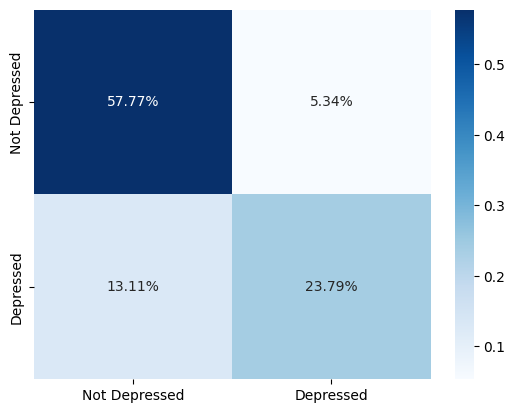

In [137]:
cf_matrix = confusion_matrix(y_test, clf.predict(X_test_unindexed))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',  xticklabels=["Not Depressed", "Depressed"], yticklabels=["Not Depressed", "Depressed"])

In [101]:
# Accuracy
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(clf,  df, y, cv=kfold, scoring="accuracy")
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 80.08% (2.46%)


In [102]:
# Recall
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
results = cross_val_score(clf,  df, y, cv=kfold, scoring="recall_macro")
print("Recall: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Recall: 75.36% (3.02%)


In [103]:
# Precision
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
results = cross_val_score(clf,  df, y, cv=kfold, scoring="precision_macro")
print("Precision: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Precision: 77.69% (3.78%)


In [104]:
# f1
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
results = cross_val_score(clf,  df, y, cv=kfold, scoring="f1_macro")
print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

F1: 76.12% (3.14%)


### XG Boost

In [37]:
clf = XGBClassifier( random_state=42)

In [38]:
clf.fit(X_train_unindexed,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [39]:
clf.score(X_test_unindexed,y_test)

0.7912621359223301

In [40]:
# Accuracy
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(clf,  df, y, cv=kfold, scoring="accuracy")
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 78.92% (5.53%)


In [41]:
# Recall
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
results = cross_val_score(clf,  df, y, cv=kfold, scoring="recall_macro")
print("Recall: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Recall: 75.68% (4.07%)


In [42]:
# Precision
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
results = cross_val_score(clf,  df, y, cv=kfold, scoring="precision_macro")
print("Precision: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Precision: 76.85% (4.40%)


In [43]:
# f1
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
results = cross_val_score(clf,  df, y, cv=kfold, scoring="f1_macro")
print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

F1: 75.94% (3.99%)


### Oversampling

In [27]:
X = features#pd.read_csv("extracted_features.csv")

In [28]:
y = y#pd.read_csv("output.csv")["0"].values

In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

## Random Forest 

In [75]:
clf = RandomForestClassifier(random_state=42)

<AxesSubplot: >

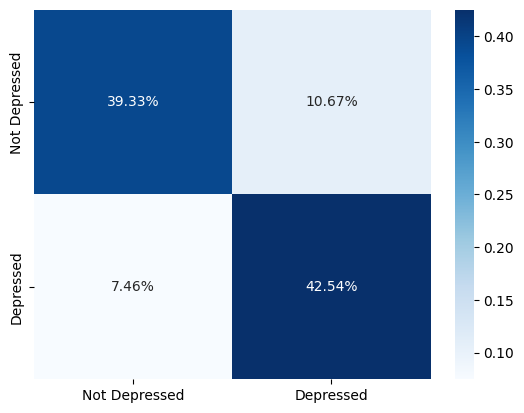

In [77]:
# Confusion Matrix

y_pred = cross_val_predict(clf, x_smote, y_smote, cv=10)
cf_matrix = confusion_matrix(y_smote, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',  xticklabels=["Not Depressed", "Depressed"], yticklabels=["Not Depressed", "Depressed"])

In [62]:
# Accuracy

kfold = KFold(n_splits=10, random_state=7,shuffle=True )
results = cross_val_score(clf, x_smote, y_smote, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 84.40% (4.31%)


In [61]:
# Recall

kfold = KFold(n_splits=10, random_state=7,shuffle=True )
results = cross_val_score(clf, x_smote, y_smote, cv=kfold, scoring='recall')
print("Recall: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Recall: 86.94% (3.58%)


In [60]:
# Precision

kfold = KFold(n_splits=10, random_state=7,shuffle=True )
results = cross_val_score(clf, x_smote, y_smote, cv=kfold, scoring='precision')
print("Precision: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Precision: 82.75% (6.79%)


In [85]:
#F1

kfold = KFold(n_splits=10, random_state=7,shuffle=True )
results = cross_val_score(clf, x_smote, y_smote, cv=kfold, scoring='f1')
print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

F1: 86.28% (2.96%)


## XGBoost

In [86]:
clf = XGBClassifier(random_state=42)

<AxesSubplot: >

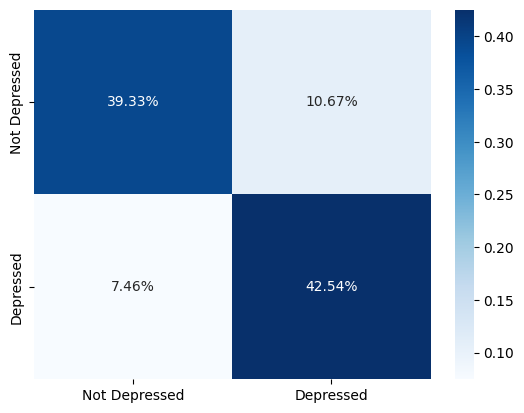

In [84]:
# Confusion Matrix

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',  xticklabels=["Not Depressed", "Depressed"], yticklabels=["Not Depressed", "Depressed"])

In [79]:
# Accuracy

kfold = KFold(n_splits=10, random_state=7,shuffle=True )
results = cross_val_score(clf, x_smote, y_smote, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 86.04% (2.99%)


In [80]:
# Recall

kfold = KFold(n_splits=10, random_state=7,shuffle=True )
results = cross_val_score(clf, x_smote, y_smote, cv=kfold, scoring='recall')
print("Recall: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Recall: 88.28% (2.60%)


In [87]:
# Precision

kfold = KFold(n_splits=10, random_state=7,shuffle=True )
results = cross_val_score(clf, x_smote, y_smote, cv=kfold, scoring='precision')
print("Precision: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Precision: 84.59% (5.41%)


In [82]:
# F1

kfold = KFold(n_splits=10, random_state=7,shuffle=True )
results = cross_val_score(clf, x_smote, y_smote, cv=kfold, scoring='f1')
print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

F1: 86.28% (2.96%)


### Saving the Model

In [87]:
filename = 'final_model.sav'
pickle.dump(clf, open(filename, 'wb'))

### Loading the Model

In [72]:
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test_unindexed, y_test)